In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 14

In [2]:
walkers = ['walkerA', 'walkerB', 'walkerC', 'walkerD', 'walkerE']
data = pd.read_csv(f'../data/processed/bk_input_data.csv', index_col=0)

bk_data = data.drop(['label'], axis=1).query(f'index.str.contains("BK")', engine='python').values
correct_data = data.drop(['label'], axis=1).query(f'index.str.contains("Correct")', engine='python').values
walker_data = {}
for w in walkers:
    walker_data[w] = data.query(f'index.str.contains("{w}")', engine='python')

coef_lst = []
for w in walkers:
    if w == 'walkerE': continue
    test_walker = w
    train_data = pd.DataFrame()
    for k, v in walker_data.items():
        if k == test_walker: continue
        train_data = pd.concat([train_data, v])
    test_data = walker_data[test_walker]
    
    train_scaler = StandardScaler()
    train_scaler.fit(train_data)
    train_data_std = pd.DataFrame(train_scaler.transform(train_data), columns=train_data.columns, index=train_data.index)
    train_data_std['label'][train_data_std['label'] < 0] = 0
    train_data_std['label'][train_data_std['label'] > 0] = 1
    train = train_data_std.sample(frac=1)

    test_scaler = StandardScaler()
    test_scaler.fit(test_data)
    test_data_std = pd.DataFrame(test_scaler.transform(test_data), columns=test_data.columns, index=test_data.index)
    test_data_std['label'][test_data_std['label'] < 0] = 0
    test_data_std['label'][test_data_std['label'] > 0] = 1
    test = test_data_std
    
    Y_train = train['label']
    X_train = train.drop(['label'], axis=1)
    Y_test = test['label']
    X_test = test.drop(['label'], axis=1)
    
    model = LogisticRegression(random_state=0, max_iter=10000)
    model.fit(X_train, Y_train)
    coef = model.coef_
    coef_lst.append(abs(coef[0].reshape(85, 9, 2)))
    predict = model.predict(X_test)
    
    print(w)
    print(f'Accuracy : {accuracy_score(y_true=Y_test, y_pred=predict):.4f}')
    print(f'Precision: {precision_score(y_true=Y_test, y_pred=predict):.4f}')
    print(f'Recall   : {recall_score(y_true=Y_test, y_pred=predict):.4f}')
    print(f'Fscore   : {f1_score(y_true=Y_test, y_pred=predict):.4f}')
    print('')

walkerA
Accuracy : 0.8500
Precision: 1.0000
Recall   : 0.8065
Fscore   : 0.8929

walkerB
Accuracy : 0.9662
Precision: 0.9254
Recall   : 1.0000
Fscore   : 0.9612

walkerC
Accuracy : 0.9149
Precision: 0.8636
Recall   : 0.9500
Fscore   : 0.9048

walkerD
Accuracy : 0.9722
Precision: 0.9348
Recall   : 1.0000
Fscore   : 0.9663



Text(0.5, 0, 'Importance')

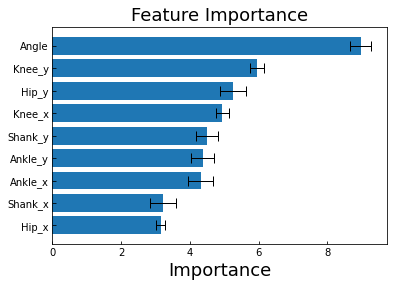

In [3]:
coef_lst = np.array(coef_lst)
coef_dict = {'Hip_x': coef_lst[:, :, 0, 0] + coef_lst[:, :, 1, 0],
            'Hip_y': coef_lst[:, :, 0, 1] + coef_lst[:, :, 1, 1],
            'Knee_x': coef_lst[:, :, 2, 0] + coef_lst[:, :, 4, 0],
            'Knee_y': coef_lst[:, :, 2, 1] + coef_lst[:, :, 4, 1],
            'Shank_x': coef_lst[:, :, 3, 0] + coef_lst[:, :, 5, 0],
            'Shank_y': coef_lst[:, :, 3, 1] + coef_lst[:, :, 5, 1],
            'Ankle_x': coef_lst[:, :, 6, 0] + coef_lst[:, :, 7, 0],
            'Ankle_y': coef_lst[:, :, 6, 1] + coef_lst[:, :, 7, 1],
            'Angle': coef_lst[:, :, 8, 0] + coef_lst[:, :, 8, 1]}

coef_std = {}
coef_mean = {}
for k, v in coef_dict.items():
    coef_mean[k] = v.sum(axis=1).mean(axis=0)
    coef_std[k] = v.sum(axis=1).std(axis=0) / np.sqrt(len(v.sum(axis=1)))

df_coef_std = pd.DataFrame(list(coef_std.items()), columns=['Features', 'Std'])
df_coef_mean = pd.DataFrame(list(coef_mean.items()), columns=['Features', 'Mean'])
importance = pd.merge(df_coef_std, df_coef_mean, on='Features')
importance = importance.sort_values('Mean')

error_bar_set = dict(lw = 1, capthick = 1, capsize = 5)
plt.barh(importance['Features'], importance['Mean'], xerr=importance['Std'], error_kw=error_bar_set)
plt.title('Feature Importance', fontsize=18)
plt.xlabel('Importance', fontsize=18)

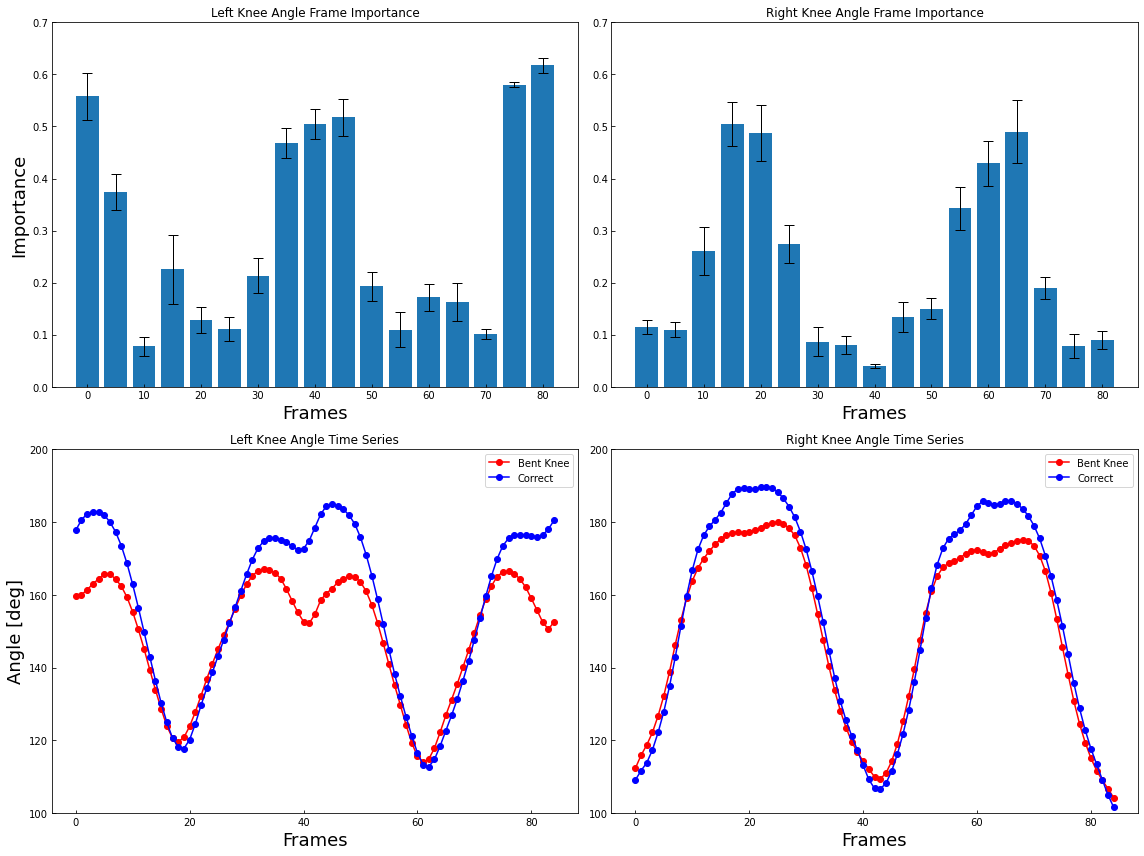

In [4]:
langle = []
rangle = []
imp_langle = coef_lst[:, :, 8, 0]
imp_rangle = coef_lst[:, :, 8, 1]

for i in range(int(85/5)):
    langle.append(imp_langle[:, i*5:i*5+5].sum(axis=1))
    rangle.append(imp_rangle[:, i*5:i*5+5].sum(axis=1))

langle = np.array(langle)
rangle = np.array(rangle)
langle_mean = langle.mean(axis=1)
langle_std = langle.std(axis=1) / np.sqrt(langle.shape[1])
rangle_mean = rangle.mean(axis=1)
rangle_std = rangle.std(axis=1) / np.sqrt(rangle.shape[1])

bk_num, correct_num = bk_data.shape[0], correct_data.shape[0]
bk = bk_data.reshape(bk_num, 85, 9, 2)
correct = correct_data.reshape(correct_num, 85, 9, 2)

bk_langle_mean = bk[:, :, 8, 0].mean(axis=0)
bk_rangle_mean = bk[:, :, 8, 1].mean(axis=0)
correct_langle_mean = correct[:, :, 8, 0].mean(axis=0)
correct_rangle_mean = correct[:, :, 8, 1].mean(axis=0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

frames = [x for x in range(len(langle_mean))]
ax[0][0].bar(frames, langle_mean, yerr=langle_std, error_kw=error_bar_set)
ax[0][0].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax[0][0].set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax[0][0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax[0][0].set_xlabel('Frames', fontsize=18)
ax[0][0].set_ylabel('Importance', fontsize=18)
ax[0][0].set_ylim(0, 0.7)
ax[0][0].set_title('Left Knee Angle Frame Importance')

ax[0][1].bar(frames, rangle_mean, yerr=rangle_std, error_kw=error_bar_set)
ax[0][1].set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
ax[0][1].set_xticklabels([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax[0][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax[0][1].set_xlabel('Frames', fontsize=18)
ax[0][1].set_ylim(0, 0.7)
ax[0][1].set_title('Right Knee Angle Frame Importance')

frames = [x for x in range(len(bk_langle_mean))]
ax[1][0].plot(frames, bk_langle_mean, color='red', marker='o', label='Bent Knee')
ax[1][0].plot(frames, correct_langle_mean, color='blue', marker='o', label='Correct')
ax[1][0].set_xlabel('Frames', fontsize=18)
ax[1][0].set_ylabel('Angle [deg]', fontsize=18)
ax[1][0].set_ylim(100, 200)
ax[1][0].set_title('Left Knee Angle Time Series')
ax[1][0].legend()

ax[1][1].plot(frames, bk_rangle_mean, color='red', marker='o', label='Bent Knee')
ax[1][1].plot(frames, correct_rangle_mean, color='blue', marker='o', label='Correct')
ax[1][1].set_xlabel('Frames', fontsize=18)
ax[1][1].set_ylim(100, 200)
ax[1][1].set_title('Right Knee Angle Time Series')
ax[1][1].legend()

plt.tight_layout()